<a href="https://colab.research.google.com/github/pngy87/-PTDLNC-GOOGLE-COLAB/blob/main/%5BCHAPTER%204%5DDiagnostic_Analytic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#load data
import gdown
url = "https://drive.google.com/uc?id=14kGMTPKZKjFJEDZj3DCMCjXR2mEUJrhP"
file_path = "Sample - Superstore.xls"
gdown.download(url, file_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14kGMTPKZKjFJEDZj3DCMCjXR2mEUJrhP
To: /content/Sample - Superstore.xls
100%|██████████| 1.34M/1.34M [00:00<00:00, 133MB/s]


'Sample - Superstore.xls'

In [ ]:
# --- 0) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, levene

In [ ]:
#--- 1)Read data
import pandas as pd
# Read sheets
orders = pd.read_excel(file_path, sheet_name="Orders", parse_dates=["Order Date", "Ship Date"])
returns = pd.read_excel(file_path, sheet_name="Returns")  # usually has "Order ID"
people  = pd.read_excel(file_path, sheet_name="People")   # optional for region managers


In [ ]:
orders

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [ ]:
# --- 2) Basic cleaning / feature engineering
# Ensure column names are safe and consistent
orders.columns = [c.strip().replace(" ", "_") for c in orders.columns]
returns.columns = [c.strip().replace(" ", "_") for c in returns.columns]

# Create a "Returned" flag by merging with Returns on Order_ID
orders["Returned"] = orders["Order_ID"].isin(returns["Order_ID"])

# Create helpful features
orders["Gross_Margin"] = orders["Profit"] / orders["Sales"]
orders["High_Discount"] = orders["Discount"] >= 0.30
orders["Year"] = orders["Order_Date"].dt.year
orders["Month"] = orders["Order_Date"].dt.to_period("M").astype(str)

In [ ]:
orders

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,...,Product_Name,Sales,Quantity,Discount,Profit,Returned,Gross_Margin,High_Discount,Year,Month
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,False,0.1600,False,2016,2016-11
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,False,0.3000,False,2016,2016-11
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,False,0.4700,False,2016,2016-06
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,False,-0.4000,True,2015,2015-10
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,False,0.1125,False,2015,2015-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,Ultra Door Pull Handle,25.2480,3,0.20,4.1028,False,0.1625,False,2014,2014-01
9990,9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332,True,0.1700,False,2017,2017-02
9991,9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932,True,0.0750,False,2017,2017-02
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200,True,0.4500,False,2017,2017-02


In [ ]:
# ---------- 4) Top-line Summary (Descriptive → context for diagnostics) ----------
summary = {
    "Total_Sales": orders["Sales"].sum(),
    "Total_Profit": orders["Profit"].sum(),
    "Orders(nunique)": orders["Order_ID"].nunique(),
    "Rows": len(orders),
    "Loss_Orders_%": 100 * (orders["Profit"] < 0).mean(),
    "Return_Rate_%": 100 * orders["Returned"].mean(),
    "Corr(Discount,Profit)": orders["Discount"].corr(orders["Profit"]),
}
print("\n=== Top-line Summary ===")
for k, v in summary.items():
    print(f"{k:>22}: {v:,.4f}" if isinstance(v, (int, float, np.floating)) else f"{k:>22}: {v}")



=== Top-line Summary ===
           Total_Sales: 2,297,200.8603
          Total_Profit: 286,397.0217
       Orders(nunique): 5,009.0000
                  Rows: 9,994.0000
         Loss_Orders_%: 18.7212
         Return_Rate_%: 8.0048
 Corr(Discount,Profit): -0.2195



=== Diagnostic 1A: Discount vs Profit (Correlation) ===
Pearson corr(Discount, Profit) = -0.2195 (negative ⇒ higher discount → lower profit)


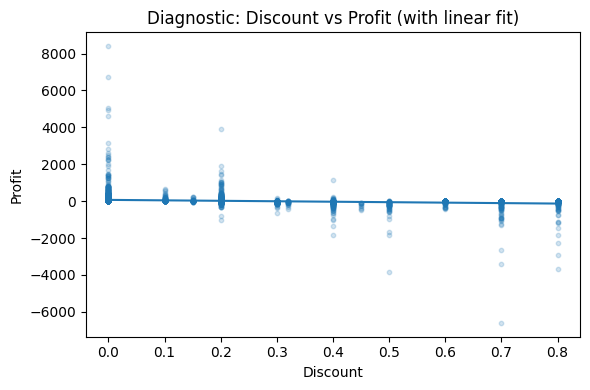

In [ ]:
# =========================
# DIAGNOSTIC 1: Is discount driving losses?
# =========================
# 1A) Correlation
corr = orders["Discount"].corr(orders["Profit"])
print("\n=== Diagnostic 1A: Discount vs Profit (Correlation) ===")
print(f"Pearson corr(Discount, Profit) = {corr:.4f} (negative ⇒ higher discount → lower profit)")

# 1B) Simple linear fit (visual diagnostic)
x = orders["Discount"].values
y = orders["Profit"].values
a, b = np.polyfit(x, y, deg=1)  # y = a*x + b

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.2, s=10)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = a*x_line + b
plt.plot(x_line, y_line)
plt.title("Diagnostic: Discount vs Profit (with linear fit)")
plt.xlabel("Discount")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()



=== Diagnostic 2A: Profit by Sub-Category (ascending) ===
   Sub-Category      Profit
16       Tables -17725.4811
4     Bookcases  -3472.5560
15     Supplies  -1189.0995
8     Fasteners    949.5182
11     Machines   3384.7569
10       Labels   5546.2540
2           Art   6527.7870
7     Envelopes   6964.1767
9   Furnishings  13059.1436
1    Appliances  18138.0054

=== Diagnostic 2B: Pareto of Losses by Sub-Category ===
   Sub-Category      Profit    Abs_Loss  Cum_Share_of_Loss_%
16       Tables -17725.4811  17725.4811             79.17708
4     Bookcases  -3472.5560   3472.5560             94.68847
15     Supplies  -1189.0995   1189.0995            100.00000


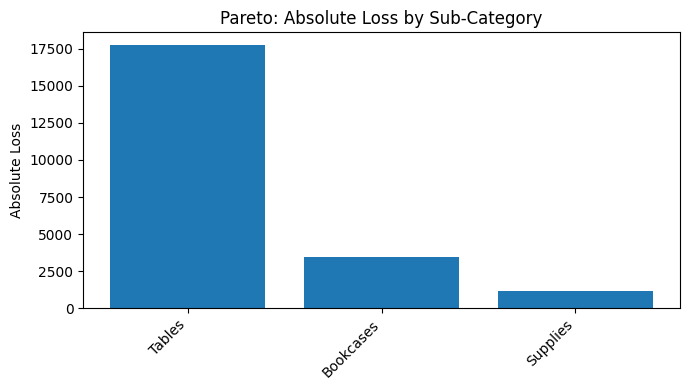

In [ ]:
# =========================
# DIAGNOSTIC 2: Which sub-categories are causing losses?
# =========================
subc_profit = (orders.groupby("Sub-Category", as_index=False)["Profit"]
               .sum()
               .sort_values("Profit"))
print("\n=== Diagnostic 2A: Profit by Sub-Category (ascending) ===")
print(subc_profit.head(10))  # worst first

loss_tbl = subc_profit[subc_profit["Profit"] < 0].copy()
loss_tbl["Abs_Loss"] = loss_tbl["Profit"].abs()
loss_tbl = loss_tbl.sort_values("Abs_Loss", ascending=False)
loss_tbl["Cum_Share_of_Loss_%"] = 100 * loss_tbl["Abs_Loss"].cumsum() / loss_tbl["Abs_Loss"].sum()

print("\n=== Diagnostic 2B: Pareto of Losses by Sub-Category ===")
print(loss_tbl[["Sub-Category", "Profit", "Abs_Loss", "Cum_Share_of_Loss_%"]])

plt.figure(figsize=(7,4))
plt.bar(loss_tbl["Sub-Category"], loss_tbl["Abs_Loss"])
plt.xticks(rotation=45, ha="right")
plt.title("Pareto: Absolute Loss by Sub-Category")
plt.ylabel("Absolute Loss")
plt.tight_layout()
plt.show()


=== Diagnostic 3: Drill-down in worst Sub-Category ===
Worst Sub-Category: Tables

Profit by Region for worst Sub-Category:
    Region      Profit
1     East -11025.3801
2    South  -4623.0579
0  Central  -3559.6504
3     West   1482.6073

Profit by Ship Mode for worst Sub-Category:
        Ship_Mode      Profit
3  Standard Class -11910.0122
2    Second Class  -3320.6799
0     First Class  -1365.3665
1        Same Day  -1129.4225

Profit by Discount Bucket (coarse):
  Discount_Bucket      Profit    N
1          20–40% -19589.7244  129
2            >40% -11108.4984   47
0            ≤20%  12972.7417  143


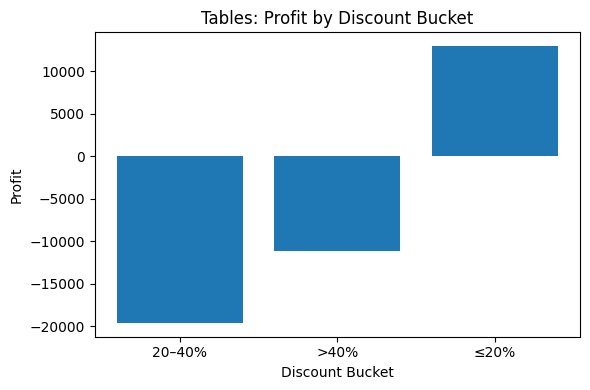

In [ ]:
# =========================
# DIAGNOSTIC 3 (Simplified): Drill-down within the worst sub-category
# =========================
worst_subc = loss_tbl.iloc[0]["Sub-Category"] if not loss_tbl.empty else None
print("\n=== Diagnostic 3: Drill-down in worst Sub-Category ===")
print(f"Worst Sub-Category: {worst_subc}")

if worst_subc is not None:
    df_worst = orders[orders["Sub-Category"] == worst_subc].copy()

    # A) Profit by Region and Ship Mode (simple views)
    region_view = (df_worst.groupby("Region", as_index=False, observed=False)["Profit"]
                   .sum()
                   .sort_values("Profit"))
    print("\nProfit by Region for worst Sub-Category:")
    print(region_view)

    ship_view = (df_worst.groupby("Ship_Mode", as_index=False, observed=False)["Profit"]
                 .sum()
                 .sort_values("Profit"))
    print("\nProfit by Ship Mode for worst Sub-Category:")
    print(ship_view)

    # B) Coarse Discount buckets (fewer bins → fewer sparse groups)
    bins   = [-0.01, 0.20, 0.40, 1.00]
    labels = ["≤20%", "20–40%", ">40%"]
    df_worst["Discount_Bucket"] = pd.cut(
        df_worst["Discount"], bins=bins, labels=labels, include_lowest=True
    )

    disc_view = (df_worst
                 .groupby("Discount_Bucket", as_index=False, observed=False)
                 .agg(Profit=("Profit", "sum"),
                      N=("Profit", "size"))
                 .sort_values("Profit"))
    print("\nProfit by Discount Bucket (coarse):")
    print(disc_view)

        # Visual: Profit by Discount Bucket
    plt.figure(figsize=(6,4))
    plt.bar(disc_view["Discount_Bucket"].astype(str), disc_view["Profit"])
    plt.title(f"{worst_subc}: Profit by Discount Bucket")
    plt.xlabel("Discount Bucket")
    plt.ylabel("Profit")
    plt.tight_layout()
    plt.show()



=== Diagnostic 4A: Return Rate by Ship Mode ===
        Ship_Mode  Orders  Return_Rate_%
1        Same Day     543      11.786372
0     First Class    1538       9.882965
3  Standard Class    5968       7.540214
2    Second Class    1945       6.889460

=== Diagnostic 4B: Return Rate by Sub-Category (Top 10) ===
   Sub-Category  Orders  Return_Rate_%
11     Machines     115      11.304348
16       Tables     319       9.404389
3       Binders    1523       8.995404
12        Paper    1370       8.978102
8     Fasteners     217       8.755760
13       Phones     889       8.661417
5        Chairs     617       8.589951
1    Appliances     466       8.583691
15     Supplies     190       8.421053
0   Accessories     775       7.870968


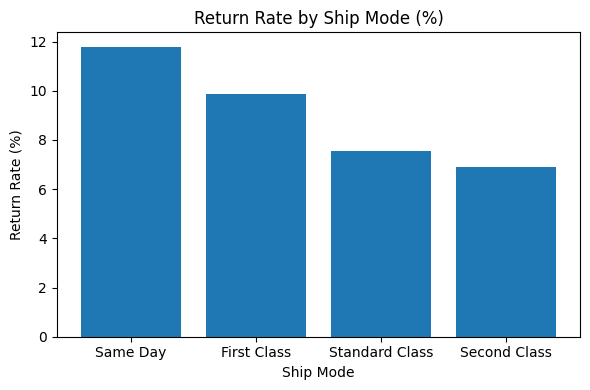

In [ ]:
# =========================
# DIAGNOSTIC 4: Are returns associated with certain ship modes or sub-categories?
# =========================
ret_by_ship = (orders.groupby("Ship_Mode")
               .agg(Return_Rate=("Returned", "mean"),
                    Orders=("Returned", "size"))
               .reset_index()
               .sort_values("Return_Rate", ascending=False))
ret_by_ship["Return_Rate_%"] = 100 * ret_by_ship["Return_Rate"]
print("\n=== Diagnostic 4A: Return Rate by Ship Mode ===")
print(ret_by_ship[["Ship_Mode", "Orders", "Return_Rate_%"]])

ret_by_subc = (orders.groupby("Sub-Category")
               .agg(Return_Rate=("Returned", "mean"),
                    Orders=("Returned", "size"))
               .reset_index()
               .sort_values("Return_Rate", ascending=False))
ret_by_subc["Return_Rate_%"] = 100 * ret_by_subc["Return_Rate"]
print("\n=== Diagnostic 4B: Return Rate by Sub-Category (Top 10) ===")
print(ret_by_subc.head(10)[["Sub-Category", "Orders", "Return_Rate_%"]])

plt.figure(figsize=(6,4))
plt.bar(ret_by_ship["Ship_Mode"], ret_by_ship["Return_Rate_%"])
plt.title("Return Rate by Ship Mode (%)")
plt.xlabel("Ship Mode")
plt.ylabel("Return Rate (%)")
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# DIAGNOSTIC 5: Are certain segments/regions systematically less profitable?
# =========================
seg_region = (orders.groupby(["Segment", "Region"], as_index=False)
              .agg(Profit=("Profit", "sum"),
                   Sales=("Sales", "sum"),
                   Orders=("Order_ID", "nunique")))
seg_region["Profit_Margin_%"] = 100 * seg_region["Profit"] / seg_region["Sales"]
print("\n=== Diagnostic 5: Segment x Region performance ===")
print(seg_region.sort_values("Profit_Margin_%").head(10))


=== Diagnostic 5: Segment x Region performance ===
        Segment   Region      Profit        Sales  Orders  Profit_Margin_%
0      Consumer  Central   8564.0481  252031.4340     604         3.398008
10  Home Office    South   4620.6343   74255.0015     131         6.222657
1      Consumer     East  41190.9843  350908.1670     713        11.738394
5     Corporate     East  23622.5789  200409.3470     434        11.787164
4     Corporate  Central  18703.9020  157995.8128     348        11.838226
11  Home Office     West  16530.4150  136721.7770     301        12.090550
6     Corporate    South  15215.2232  121885.9325     247        12.483166
8   Home Office  Central  12438.4124   91212.6440     223        13.636719
2      Consumer    South  26913.5728  195580.9710     444        13.760834
7     Corporate     West  34437.4299  225855.2745     485        15.247565


**ANOVA Testing**

We use ANOVA to examine whether the average order-level profit margin differs across Regions (e.g., Central, East, South, West). ANOVA compares the variation in profit margin between Regions to the variation within each Region.

H0 (null hypothesis): The mean order-level profit margin is the same across all Regions:

H1 (alternative hypothesis): At least one Region has a different mean order-level profit margin (i.e., not all regional means are equal).

If the p-value is below 0.05, we conclude that profit margins are not the same across Region

In [ ]:
import numpy as np
import pandas as pd

# orders: line-item dataframe (mỗi dòng = 1 sản phẩm trong 1 order)

def build_order_level_df(orders: pd.DataFrame) -> pd.DataFrame:
    df = orders.copy()

    # đảm bảo datetime
    df["Order_Date"] = pd.to_datetime(df["Order_Date"], errors="coerce")
    df["Ship_Date"]  = pd.to_datetime(df["Ship_Date"],  errors="coerce")
    df["_disc_x_sales"] = df["Discount"] * df["Sales"]

    agg = {
        # keys/categoricals (thường là cố định trong 1 order)
        "Order_Date": "first",
        "Ship_Date": "first",
        "Region": "first",
        "Segment": "first",
        "Ship Mode": "first",
        "Customer_ID": "first",    # nếu có
        "State": "first",          # nếu có
        "City": "first",           # nếu có

        # numeric totals
        "Sales": "sum",
        "Profit": "sum",
        "Quantity": "sum",

        # weighted discount components
        "_disc_x_sales": "sum",
    }

    # chỉ giữ những cột có tồn tại trong df (tránh KeyError nếu thiếu cột)
    agg = {k: v for k, v in agg.items() if k in df.columns}

    order_df = (
        df.groupby("Order_ID", as_index=False)
          .agg(agg)
    )

    # ship days (lead time)
    if "Order_Date" in order_df.columns and "Ship_Date" in order_df.columns:
        order_df["ship_days"] = (order_df["Ship_Date"] - order_df["Order_Date"]).dt.days

    # sales-weighted discount
    if "_disc_x_sales" in order_df.columns:
        # nếu Sales=0 thì weighted discount không xác định -> NaN
        order_df["discount_wavg"] = np.where(
            order_df["Sales"] != 0,
            order_df["_disc_x_sales"] / order_df["Sales"],
            np.nan
        )
        order_df.drop(columns=["_disc_x_sales"], inplace=True)

    # profit margin = total profit / total sales (order level)
    order_df["profit_margin"] = np.where(
        order_df["Sales"] != 0,
        order_df["Profit"] / order_df["Sales"],
        np.nan
    )

    return order_df

order_level = build_order_level_df(orders)

print(order_level.shape)
print(order_level[["Order_ID","Region","Sales","Profit","profit_margin"]].head())


(5009, 14)
         Order_ID Region    Sales    Profit  profit_margin
0  CA-2014-100006   East  377.970  109.6113       0.290000
1  CA-2014-100090   West  699.192  -19.0890      -0.027302
2  CA-2014-100293  South   91.056   31.8696       0.350000
3  CA-2014-100328   East    3.928    1.3257       0.337500
4  CA-2014-100363   West   21.376    7.7192       0.361115


/tmp/ipython-input-420062078.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=regions, showfliers=True)


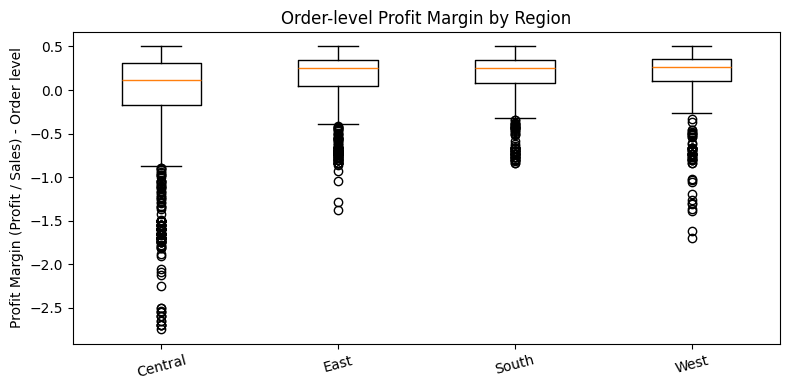

In [ ]:
import matplotlib.pyplot as plt

# boxplot theo Region
regions = sorted(order_level["Region"].dropna().unique())
data = [order_level.loc[order_level["Region"] == r, "profit_margin"].dropna().values for r in regions]

plt.figure(figsize=(8, 4))
plt.boxplot(data, labels=regions, showfliers=True)
plt.ylabel("Profit Margin (Profit / Sales) - Order level")
plt.title("Order-level Profit Margin by Region")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


#

In [ ]:
from statsmodels.stats.oneway import anova_oneway

# chuẩn bị groups
regions = sorted(order_level["Region"].dropna().unique())
groups = [
    order_level.loc[order_level["Region"] == r, "profit_margin"].dropna().values
    for r in regions
]

# Welch ANOVA (unequal variances)
res = anova_oneway(groups, use_var="unequal")

print("Regions:", regions)
print("Welch ANOVA result:", res)
# res.statistic, res.pvalue, res.df_num, res.df_denom


Regions: ['Central', 'East', 'South', 'West']
Welch ANOVA result: statistic = 73.86584308727822
pvalue = 1.1345175495498921e-45
df = (3.0, np.float64(2372.1817793226287))
df_num = 3.0
df_denom = 2372.1817793226287
nobs_t = 5009.0
n_groups = 4
means = [-0.08740328  0.14996805  0.15848984  0.20446165]
nobs = [1175. 1401.  822. 1611.]
vars_ = [0.42255742 0.09206187 0.0804401  0.0616048 ]
use_var = unequal
welch_correction = True
tuple = (np.float64(73.86584308727822), np.float64(1.1345175495498921e-45))


**Chi-square Testing**

Business question: Does the product category mix (Furniture / Office Supplies / Technology) vary by Region (Central / East / South / West)?

H0: Category and Region are independent (the category distribution is the same across regions).

H1: Category and Region are associated (at least one region has a different category distribution).

Contingency table (counts):
Category  Furniture  Office Supplies  Technology
Region                                          
Central         481             1422         420
East            601             1712         535
South           332              995         293
West            707             1897         599

Chi-square test results:
chi2 = 3.6619, dof = 6, p-value = 0.722316


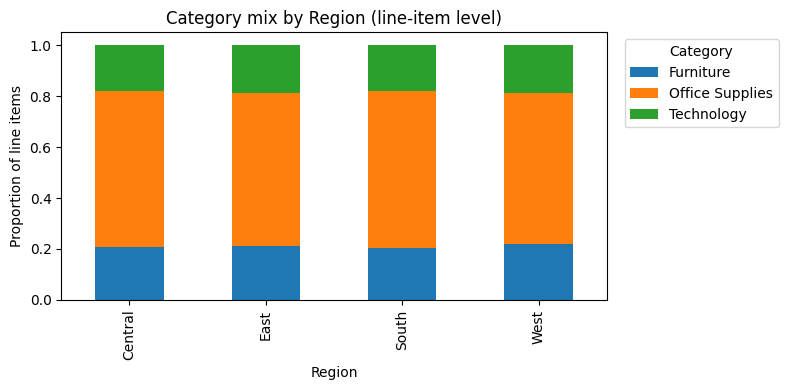

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# orders: dataframe line-item đã load sẵn
# cần có 2 cột: 'Region' và 'Category'

# 1) Contingency table
ct = pd.crosstab(orders["Region"], orders["Category"])
print("Contingency table (counts):")
print(ct)

# 2) Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(ct)

print("\nChi-square test results:")
print(f"chi2 = {chi2:.4f}, dof = {dof}, p-value = {p:.6g}")

# Stacked bar chart (proportions) for easier comparison
prop = ct.div(ct.sum(axis=1), axis=0)

ax = prop.plot(kind="bar", stacked=True, figsize=(8,4))
ax.set_ylabel("Proportion of line items")
ax.set_title("Category mix by Region (line-item level)")
ax.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

Result  p = 0.7223
Because p > 0.05, we fail to reject H0. There is no statistical evidence that the category mix differs by region at the line-item level. The stacked bar chart also shows very similar proportions across regions.